In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

import allinone as aio

%matplotlib inline
warnings.filterwarnings('ignore')
pd.set_option("display.float_format", "{:.3f}".format)
plt.style.use('ggplot')

In [2]:
df = pd.read_csv('hmelq_clean.csv')

In [3]:
df.head(3)

,bad,loan,mortdue,value,reason,job,yoj,derog,delinq,clage,ninq,clno,debtinc
0,0,29.311,64.074,16.199,HomeImp,Other,28.000,0.000,0.000,18.711,0.000,14.000,13.321
1,0,19.771,112.857,16.569,DebtCon,Other,2.000,0.000,0.000,18.002,0.000,25.000,13.443
2,0,21.390,86.871,14.924,DebtCon,Other,5.000,0.000,0.000,15.992,2.000,9.000,11.077


### Dummy

In [4]:
dfCopy = df.copy()

dms = pd.get_dummies(dfCopy[['reason','job']])
Xn_ = dfCopy.drop(['reason','job'], axis=1)
dfDummy = pd.concat([Xn_,dms], axis=1)
dfDummy = dfDummy.drop(['reason_DebtCon'], axis=1)

In [5]:
dfDummy.head(3)

,bad,loan,mortdue,value,yoj,derog,delinq,clage,ninq,clno,debtinc,reason_HomeImp,job_Mgr,job_Office,job_Other,job_ProfEx,job_Sales,job_Self
0,0,29.311,64.074,16.199,28.000,0.000,0.000,18.711,0.000,14.000,13.321,1,0,0,1,0,0,0
1,0,19.771,112.857,16.569,2.000,0.000,0.000,18.002,0.000,25.000,13.443,0,0,0,1,0,0,0
2,0,21.390,86.871,14.924,5.000,0.000,0.000,15.992,2.000,9.000,11.077,0,0,0,1,0,0,0


## Model

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [7]:
y = dfDummy.bad
X = dfDummy.drop(['bad'], axis=1)

model = RandomForestClassifier()

In [8]:
aio.confusion(X, y, model)

Accuracy: 0.91341 | AUC: 0.95624


,pred_0,pred_1,precision,recall,f1-score,support
0,576,15,0.925,0.975,0.949,591.000
1,47,78,0.839,0.624,0.716,125.000


In [14]:
dfModel = pd.DataFrame(columns = ['cross-score', 'cross-train', 'train_score', 'test_score', 'precision', 'recall', 'f1-score', 'auc-roc', 'auc-pr'])

In [15]:
y = dfDummy.bad
X = dfDummy.drop(['bad'], axis=1)
model = LogisticRegression()

dfModel = dfModel.append(aio.modelframe(X, y, model, 'logistic'))

In [16]:
y = dfDummy.bad
X = dfDummy.drop(['bad'], axis=1)
model = DecisionTreeClassifier()

dfModel = dfModel.append(aio.modelframe(X, y, model, 'tree'))

In [17]:
y = dfDummy.bad
X = dfDummy.drop(['bad'], axis=1)
model = RandomForestClassifier()

dfModel = dfModel.append(aio.modelframe(X, y, model, 'forest'))

In [18]:
dfModel

,cross-score,cross-train,train_score,test_score,precision,recall,f1-score,auc-roc,auc-pr
logistic,0.837,0.836,0.839,0.853,0.647,0.352,0.456,0.782,0.539
tree,0.866,0.843,1.000,0.855,0.580,0.608,0.594,0.757,0.628
forest,0.914,0.908,1.000,0.915,0.848,0.624,0.719,0.954,0.861


### Parametreler

In [24]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier

In [37]:
y = dfDummy.bad
X = dfDummy.drop(['bad'], axis=1)

rforest = RandomForestClassifier()
params = {'n_estimators': np.arange(10, 200, 20), 'max_features': ['auto', 'log2']}

In [38]:
k_fold = KFold(n_splits = 10, shuffle = True, random_state = 42)
gridcv_results = GridSearchCV(estimator = rforest, param_grid = params, cv = k_fold, n_jobs = -1, verbose = 1).fit(X, y)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   33.1s finished


In [39]:
gridcv_results.best_params_

{'max_features': 'auto', 'n_estimators': 70}

In [19]:
model = RandomForestClassifier(max_features='auto', n_estimators= 70)

dfModel = dfModel.append(aio.modelframe(X, y, model, 'forest_p1'))

In [20]:
model = RandomForestClassifier(max_features='log2', n_estimators= 110)

dfModel = dfModel.append(aio.modelframe(X, y, model, 'forest_p2'))

In [21]:
dfModel

,cross-score,cross-train,train_score,test_score,precision,recall,f1-score,auc-roc,auc-pr
logistic,0.837,0.836,0.839,0.853,0.647,0.352,0.456,0.782,0.539
tree,0.866,0.843,1.000,0.855,0.580,0.608,0.594,0.757,0.628
forest,0.914,0.908,1.000,0.915,0.848,0.624,0.719,0.954,0.861
forest_p1,0.914,0.909,1.000,0.913,0.854,0.608,0.710,0.952,0.854
forest_p2,0.915,0.908,1.000,0.919,0.853,0.648,0.736,0.953,0.855


In [40]:
rforest = RandomForestClassifier()
params = {'max_depth': range(10,100)}

k_fold = KFold(n_splits = 10, shuffle = True, random_state = 42)
gridcv_results = GridSearchCV(estimator = rforest, param_grid = params, cv = k_fold, n_jobs = -1, verbose = 0).fit(X, y)

grid_cv = pd.DataFrame(gridcv_results.cv_results_)
#grid_cv = grid_cv.sort_values(by='mean_test_score', ascending = False)
grid_sort = grid_cv.sort_values(by=['param_max_depth'])

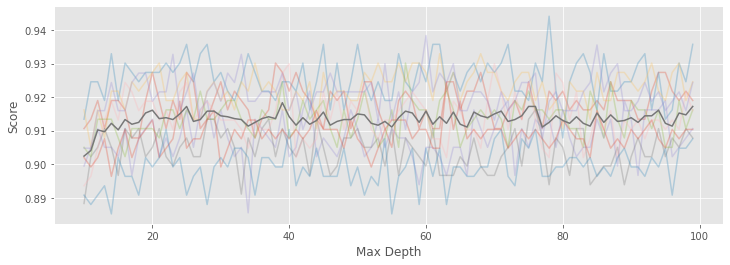

In [43]:
plt.figure(figsize=(12,4))
plt.plot(range(10,100), grid_sort.iloc[:,6:16], alpha=0.3)
plt.plot(range(10,100), grid_sort.iloc[:,16])
plt.xlabel('Max Depth')
plt.ylabel('Score');

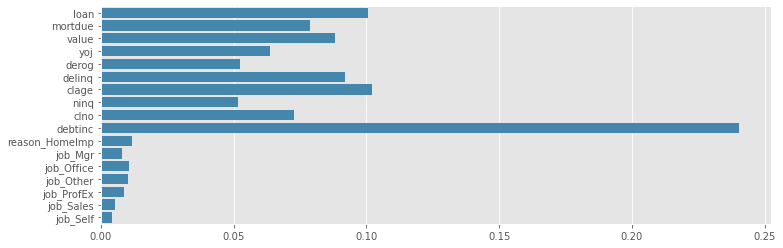

In [37]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
model = RandomForestClassifier().fit(x_train, y_train)

plt.figure(figsize=(12,4))
sns.barplot(model.feature_importances_, x_train.columns, color = '#348ABD');

## Sonuç

- Açıklayıcılık diğer yöntemlere göre oldukça iyi sonuçlandı. Yöntem, score için iyi bir performans göstermiş olsa da recall değeri üzerinde çok fazla bir etkisi olmadı. Ama iyi müşteri tahmini daha da iyileşti.
- Diğer yöntemlere göre işlem süresi biraz fazlalık gösterdi. Ama alınan performans sonuçları göz önüne alınınca tercih edilebilir.
- Parametrik iyileştirmler yapıldıktan sonra auc ve recall değerleri için max sayılar gözlemlendi. Maliyet kaynaklı parametrik değişiklikler ile en iyi recall alınmaya çalışıldı.
    - maxfeatures: auto, nestimators: 100
- Cross bölünme yapılmış 10 farklı test seti üzerinde nestimators davranışı incelendi. Overfit'in önüne geçebilmek için çok yüksek-düşük performanslar optimize edildi ve ortalama değer grafikleştirildi. 0.95 ve 0.88 aralığında değişen score değeri için en optimum değer 0.91 olarak sonuçlandı. 
- Model için önem sırası incelendiğinde, borç/gelir oranı en önemli, meslek sınıfı ve kredi tipi ise en önemsiz özellik olarak sonuçlandı.